# Exmamining the TCR Beta Chain Repertoire Through Time

This notebook is the second notebook looking at a dataset (TCRB Time Course) from [Adaptive Biotechnology's](http://www.adaptivebiotech.com) [ImmuneAccess](https://clients.adaptivebiotech.com/login) platform. I have discussed publishing on this dataset with Ryan Emerson (remerson@adaptivebiotech.com) who said that we can publish on the dataset and that he would be open to discussing a collaboration.

From my first notebook, the primary findings was the discovery of a persistant TCR repertoire in any given individual: a subset of the TCR repertoire that persisted over all time points that consituted a larger-than-expected fraction of the TCR repertoire.

Questions:

1. How do TCRs covary through time? What is the cooccurence network? Do clonotypes of the same TCR epitope track in time?
2. How can one most easily detect the durable TCR repertoire? Are regular samples needed, or do fewer samples farther apart capture that diversity?
3. How deeply does one have to sequence each sample to detect the persistant TCR repertoire? How robust is this signal to changes in the sequencing or the number of time points?
4. How does the durable TCR repertoire overlap with public TCRs over a larger number of samples pooled from multiple studies?
5. What are the dynamics of TCRs that arise during the time course and persist?
6. Do some TCRs increase or decrease in abundance monotonically?
7. How does the persistant TCR repertoire overlap with naive or memory T cell populations?

In [1]:
import matplotlib.pyplot as plt, random, itertools
import pandas as pd, numpy as np, seaborn as sns, skbio.diversity as div
import datetime, skbio.stats.distance as distance
from collections import Counter, defaultdict
from skbio.stats import subsample_counts
from datetime import datetime
from scipy.stats import norm, spearmanr, pearsonr
sns.set_style('white')
sns.set_style('ticks')
%matplotlib inline

In [2]:
#Read in metadata
metadata = pd.read_csv('/Users/ndchu/Documents/TCR_fmt/tcrb_timecourse/tcrb_timecourse_metadata.txt',
                     sep='\t')

In [3]:
#Read in full time series data for Subject01
sub1_timecourse = pd.read_csv('/Users/ndchu/Documents/tcr_fmt/tcrb_timecourse/subject01_timecourse.tsv.gz', 
                                           sep='\t', compression='gzip')

In [5]:
#get only PBMCs from Subject01
sub1_pbmc_samples = metadata[(metadata['individual'] == 'subject01') & (metadata['cells'] == 'PBMC')]['sample_short']
sub1_pbmc_timecourse = sub1_timecourse[(sub1_timecourse['sample'].isin(sub1_pbmc_samples))]

In [10]:
#get only timecourse data from the persistent TCR epitope repertoire
sub1_pers_timecourse = pd.read_csv('/Users/ndchu/Documents/tcr_fmt/tcrb_timecourse/subject01_persistantTCRepi_timecourse.tsv.gz', 
                                           sep='\t', compression='gzip')

In [3]:
#Read in time series data for Subject02
sub2_timecourse = pd.read_csv('/Users/ndchu/Documents/tcr_fmt/tcrb_timecourse/subject02_timecourse.tsv.gz', 
                                           sep='\t', compression='gzip')

In [ ]:
#Read in time series data for Subject03
sub3_timecourse = pd.read_csv('/Users/ndchu/Documents/tcr_fmt/tcrb_timecourse/subject03_timecourse.tsv.gz', 
                                           sep='\t', compression='gzip')

In [53]:
#Read in occurence data for all TCR epitopes
epitope_occurence = pd.read_csv('/Users/ndchu/Documents/tcr_fmt/tcrb_timecourse/tcr_epitopes_occurence_all.tsv.gz',
                                sep='\t', compression='gzip')

In [4]:
#Read in occurence data for TCR epitopes in Subject01
sub1_epi_occurence = pd.read_csv('/Users/ndchu/Documents/tcr_fmt/tcrb_timecourse/tcr_epitopes_occurence_sub1.tsv.gz',
                                sep='\t', compression='gzip')

## Covariance of TCR clonotypes for the same TCR epitope

If TCR clonotypes that encode the same TCR epitope are under the same selective pressure, we expect their abundances through time to track each other. For example, for those TCR epitopes that arise in the middle of the time series, do all consituent clonotypes arise together and track each other? Is there a time lag between the arrival of clonotypes of the same epitope?

In the persistant TCR repertoire:

1. What is the distribution of covariance between random TCR epitopes and clonotypes?
2. What is the coavariance of TCR clonotypes from the same epitope?

In [7]:
#First let's look at the covariance of all pairs of persistent TCR epitopes
sub1_pers_tcrs = epitope_occurence.loc[epitope_occurence['num_occ_in_sub1_pbmc'] == 8]['tcr_epitope'].values

#get persistent time course table
sub1_pers_timecourse = sub1_pbmc_timecourse[(sub1_pbmc_timecourse['tcr_epitope'].isin(sub1_pers_tcrs))]

In [28]:
#first we need to sum each TCR over it's clonotypes for each time point
sub1_pers_sumepi = sub1_pers_timecourse.groupby(['tcr_epitope', 'sample']).sum().reset_index()

#now make a dictionary, where the key is the TCR epitope and the value is a numpy array
#of frequencies, in order of time points
time_arrays = sub1_pers_sumepi.groupby('tcr_epitope').apply(lambda x: x.sort_values('sample')['freq'].values)

In [56]:
spearman_allpw = [] #format (rho, p-value)
pearson_allpw = [] #format (Pearson coefficient, 2-tailed p-value)
#for each pairwise combination (not product, spearman/pearson are symmetrical), get correlation
#For ease of computing, option to subsample the combinations
tcr_pairs = itertools.combinations(time_arrays.index.values, 2)
tcr_pairs = random.sample(tuple(tcr_pairs), 100000)
for tcr1, tcr2 in tcr_pairs:
    spearman_allpw.append(spearmanr(time_arrays[tcr1], time_arrays[tcr2]))
    pearson_allpw.append(pearsonr(time_arrays[tcr1], time_arrays[tcr2]))

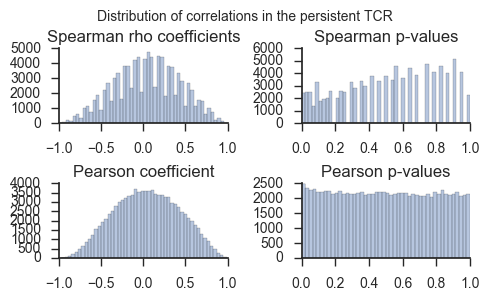

In [59]:
#plot the distribution of both correlation coefficients and p-values for the 100000 subsample
fig = plt.figure(figsize=(5, 3))
plt.suptitle('Distribution of correlations in the persistent TCR')

ax1 = fig.add_subplot(2,2,1)
sns.distplot([x[0] for x in spearman_allpw], kde=False)
plt.title('Spearman rho coefficients')

ax2 = fig.add_subplot(2,2,2)
sns.distplot([x[1] for x in spearman_allpw], kde=False)
plt.title('Spearman p-values')

ax3 = fig.add_subplot(2,2,3)
sns.distplot([x[0] for x in pearson_allpw], kde=False)
plt.title('Pearson coefficient')

ax4 = fig.add_subplot(2,2,4)
sns.distplot([x[1] for x in pearson_allpw], kde=False)
plt.title('Pearson p-values')

plt.tight_layout()
plt.subplots_adjust(top=0.85)
sns.despine()

So the random TCR pairs do look pretty random, so that's good. We can also do a similar analysis for TCR clonotypes

In [30]:
def conform_array(df, output_col, index_col, index_values, fill=np.nan):
    """
    This script takes a dataframe, and returns an array of values from the column
    output_col. The shape of the array will be of length len(index_values), and the
    order of the values will be based on the matched order of index_values and
    index_col. If index_col is missing values present in index_values, then those
    array positions will be filled with the value of "fill".
    """
    series = pd.concat([pd.Series(index=index_values), df.set_index(index_col)[output_col]], axis=1)
    if fill != np.nan:
        series = series.fillna(fill)
    return series[output_col].values

In [9]:
sample_list = ['s1_110316_PBMC',
               's1_110415_PBMC',
               's1_110512_PBMC',
               's1_110609_PBMC',
               's1_110819_PBMC',
               's1_110915_PBMC',
               's1_111014_PBMC',
               's1_120320_PBMC']

In [28]:
#Look at all covariation of pw clonotypes
#not all clonotypes are present in all timepoints, so we have to account for this
#We'll count them as zeros, since we are looking at correlations, not differential abundance
time_arrays = sub1_pers_timecourse.groupby('tcr_clonotype').apply(conform_array,
                                                                 output_col='freq',
                                                                 index_col='sample',
                                                                 index_values=sample_list,
                                                                 fill=0)

In [30]:
spearman_allpw = [] #format (rho, p-value)
pearson_allpw = [] #format (Pearson coefficient, 2-tailed p-value)
#for each pairwise combination (not product, spearman/pearson are symmetrical), get correlation
#For ease of computing, option to subsample the combinations
tcr_pairs = itertools.combinations(time_arrays.index.values, 2)
tcr_pairs = random.sample(tuple(tcr_pairs), 100000)
for tcr1, tcr2 in tcr_pairs:
    spearman_allpw.append(spearmanr(time_arrays[tcr1], time_arrays[tcr2]))
    pearson_allpw.append(pearsonr(time_arrays[tcr1], time_arrays[tcr2]))

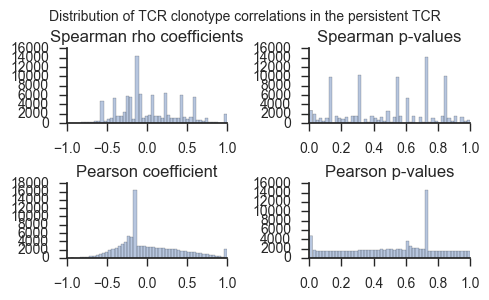

In [31]:
#plot the distribution of both correlation coefficients and p-values for the 100000 subsample
#FOR TCR CLONOTYPES, but using all clonotype that are in the persistent TCR, which is
#defined by TCR epitopes
fig = plt.figure(figsize=(5, 3))
plt.suptitle('Distribution of TCR clonotype correlations in the persistent TCR')

ax1 = fig.add_subplot(2,2,1)
sns.distplot([x[0] for x in spearman_allpw], kde=False)
plt.title('Spearman rho coefficients')

ax2 = fig.add_subplot(2,2,2)
sns.distplot([x[1] for x in spearman_allpw], kde=False)
plt.title('Spearman p-values')

ax3 = fig.add_subplot(2,2,3)
sns.distplot([x[0] for x in pearson_allpw], kde=False)
plt.title('Pearson coefficient')

ax4 = fig.add_subplot(2,2,4)
sns.distplot([x[1] for x in pearson_allpw], kde=False)
plt.title('Pearson p-values')

plt.tight_layout()
plt.subplots_adjust(top=0.85)
sns.despine()

Well, this picture for clonotypes looks a little weirder, but that is proably expected given that many TCR clonotypes are at pretty low frequency and thus a lot of these arrays were largely empty.

Let's try to identify TCR epitopes that have multiple TCR clonotypes present in all or most samples.

In [10]:
#first get the number of samples for TCR epitope and clonotype combination
tmp = sub1_pers_timecourse.groupby(['tcr_epitope', 'tcr_clonotype']).size().reset_index()
tmp = tmp.loc[tmp[0] == 8] #get only clonotypes in all 8 samples
#get how many complete clonotypes per TCR epitope
tmp = tmp.groupby('tcr_epitope').size().reset_index()
tmp = tmp.loc[tmp[0] > 1] #get multiple complete clonotypes per epitope
tmp = tmp.rename(columns={0: 'number_complete_TCR_clonotypes'})

#67 TCR epitopes with multiple clonotypes over all time points
tcre_multiple_cln = tmp.rename(columns={0: 'number_complete_TCR_clonotypes'}).reset_index(drop=True)

In [37]:
#let's look at the data from a single clone, tcr_20950
tmp = sub1_pers_timecourse.loc[sub1_pers_timecourse['tcr_epitope'] == 'tcr_20950']

#get only tcr_clonotypes that occur in at least 2 samples
tmp_list = (tmp.groupby(['tcr_clonotype']).size())[tmp.groupby(['tcr_clonotype']).size() > 1].index.tolist()
tmp = tmp.loc[tmp['tcr_clonotype'].isin(tmp_list)]

tmp['date'] = tmp['sample'].apply(lambda x: metadata.set_index('sample_short').to_dict()['time'][x])
tmp['date1'] = tmp['date'].apply(lambda x: datetime.strptime(x, '%m/%d/%y').date().toordinal())

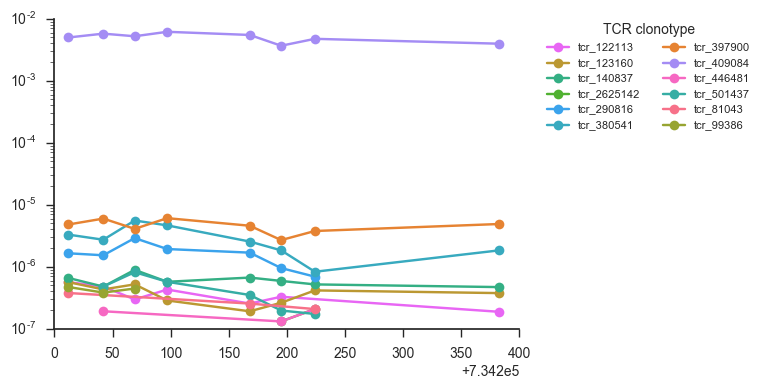

In [52]:
#plot this times series for tcr_epitope 20950
clrs = sns.color_palette("husl", 12) #make a colormap object
random.shuffle(clrs) #shuffle the colors

counter = 0
for clone, sub_df in tmp.sort_values(['tcr_clonotype', 'date1']).groupby('tcr_clonotype'):
    plt.plot(sub_df['date1'], sub_df['freq'], '-o', label=clone, color=clrs[counter])
    counter += 1

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='TCR clonotype',
          fontsize=8, ncol=2)
plt.yscale('log')
sns.despine()

In [32]:
#what is the correlation between these clonotypes?
#First get all of the largely complete TCR clonotypes
tcr_comp = (tmp.groupby(['tcr_clonotype']).size())[tmp.groupby(['tcr_clonotype']).size() > 6].index.tolist()

#get only these TCR clonotypes
tcr_20950_df = sub1_pers_timecourse.loc[sub1_pers_timecourse['tcr_clonotype'].isin(tcr_comp)]

#make time arrays for each clonotype
time_arrays_20950 = tcr_20950_df.groupby('tcr_clonotype').apply(conform_array,
                                                                output_col='freq',
                                                                index_col='sample',
                                                                index_values=sample_list,
                                                                fill=0)

#get correlation values
spearman_pw = {} #format key-(tcr1, tcr2) value-(rho, p-value)
pearson_pw = {} #format key-(tcr1, tcr2) value-(Pearson coefficient, 2-tailed p-value)
tcr_pairs = itertools.combinations(time_arrays_20950.index.values, 2)
for tcr1, tcr2 in tcr_pairs:
    spearman_pw[(tcr1, tcr2)] = spearmanr(time_arrays_20950[tcr1], time_arrays_20950[tcr2])
    pearson_pw[(tcr1, tcr2)] = pearsonr(time_arrays_20950[tcr1], time_arrays_20950[tcr2])

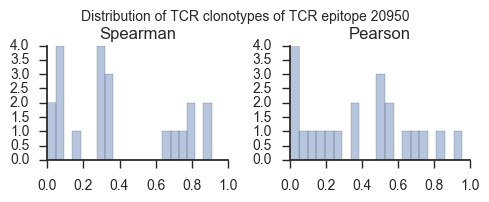

In [59]:
#plot the pvalues
fig = plt.figure(figsize=(5, 2))
plt.suptitle('Distribution of TCR clonotypes of TCR epitope 20950')

ax1 = fig.add_subplot(1,2,1)
spearman_pvals = [x[1] for x in spearman_pw.values()]
sns.distplot(spearman_pvals, kde=False, bins=20)
plt.title("Spearman")

ax2 = fig.add_subplot(1,2,2)
pearson_pvals = [x[1] for x in pearson_pw.values()]
sns.distplot(pearson_pvals, kde=False, bins=20)
plt.title("Pearson")

sns.despine()
plt.tight_layout()
plt.subplots_adjust(top=0.8)

The most obvious feature of this data is a single tcr_clonotype that numericall dominates the rest of the TCRs. This likely but not necessarily suggests that the lower abundance clones might be sequencing or PCR errors of the same prevalent clone.

The dynamics of these individual TCRs do not appear to necessarily track the overall abundance of this TCR epitope, which is almost entirely driven by the abundance of 409084. There doesn't seem to be any tight or significant correlation between the various TCR clonotypes, but maybe this would be more apparant in TCRs that arise part way through the time series. The absense of correlation might suggest that the lower abundance TCRs are not contamination/errors, since we would expect those to correlate pretty well.

Are there other TCR epitopes that seems to have multiple equally prevalent TCR clonotypes?

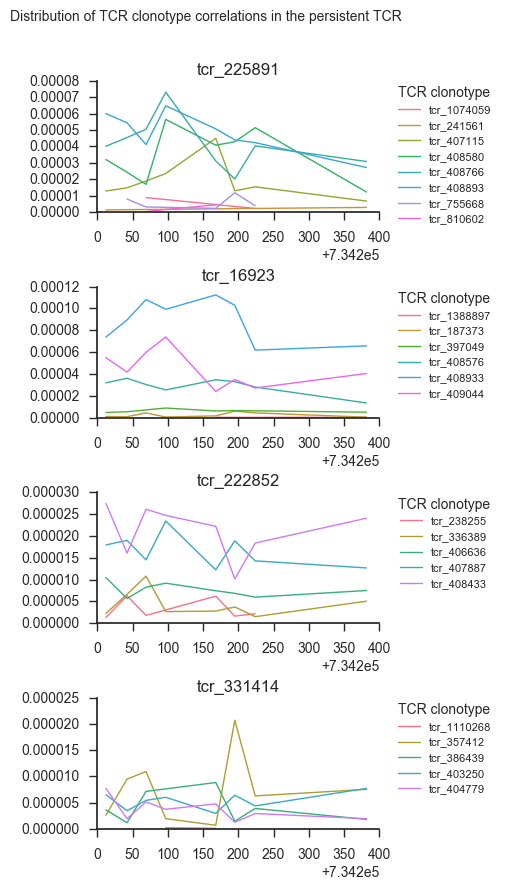

In [74]:
#plot the 4 other TCR epitopes with more than 2 TCR clonotypes in all samples
top_tcre_multiple_cln = ['tcr_225891', 'tcr_16923', 'tcr_222852', 'tcr_331414']

fig = plt.figure(figsize=(4, 9))
plt.suptitle('Distribution of TCR clonotype correlations in the persistent TCR')

plt_count = 1
for tcre in top_tcre_multiple_cln:
    tmp = sub1_pers_timecourse.loc[sub1_pers_timecourse['tcr_epitope'] == tcre]
    #get only tcr_clonotypes that occur in at least 2 samples
    tmp_list = (tmp.groupby(['tcr_clonotype']).size())[tmp.groupby(['tcr_clonotype']).size() > 1].index.tolist()
    tmp = tmp.loc[tmp['tcr_clonotype'].isin(tmp_list)]

    tmp['date'] = tmp['sample'].apply(lambda x: metadata.set_index('sample_short').to_dict()['time'][x])
    tmp['date1'] = tmp['date'].apply(lambda x: datetime.strptime(x, '%m/%d/%y').date().toordinal())
    
    ax = fig.add_subplot(4,1,plt_count)
    clrs = sns.color_palette("husl", len(tmp_list)) #organize colors

    counter = 0
    for clone, sub_df in tmp.sort_values(['tcr_clonotype', 'date1']).groupby('tcr_clonotype'):
        plt.plot(sub_df['date1'], sub_df['freq'], '-o', label=clone, color=clrs[counter],
                markersize=0, linewidth=1)
        counter += 1

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='TCR clonotype',
          fontsize=8)
    plt.title(tcre)
    
    plt_count += 1

sns.despine()
plt.tight_layout()
plt.subplots_adjust(top=0.9)

So we see that a number of epitopes don't have a dominant clonotype. Most of these TCR clonotypes have comparable abundances in the 10-6 to 10-5 range. Some of these TCRs appear to be even anti-correlated, which certainly doesn't suggest that they are merely errors.

Let's look at the correlations we get here.

In [84]:
#look at correlations of TCR clonotypes in the above plotted subsets
top_tcre_multiple_cln = ['tcr_225891', 'tcr_16923', 'tcr_222852', 'tcr_331414']

sprmn_top_tcre = {}
prsn_top_tcre = {}

for tcre in top_tcre_multiple_cln:
    tmp = sub1_pers_timecourse.loc[sub1_pers_timecourse['tcr_epitope'] == tcre]
    #get only tcr_clonotypes that occur in at least 2 samples
    tmp_list = (tmp.groupby(['tcr_clonotype']).size())[tmp.groupby(['tcr_clonotype']).size() > 1].index.tolist()
    tmp = tmp.loc[tmp['tcr_clonotype'].isin(tmp_list)]
    
    time_arrays_tmp = tmp.groupby('tcr_clonotype').apply(conform_array,
                                                         output_col='freq',
                                                         index_col='sample',
                                                         index_values=sample_list,
                                                         fill=0)
    #nest dictionary to organize results
    sprmn_top_tcre[tcre] = {}
    prsn_top_tcre[tcre] = {}
    
    tcr_pairs = itertools.combinations(time_arrays_tmp.index.values, 2)
    for tcr1, tcr2 in tcr_pairs:
        sprmn_top_tcre[tcre][(tcr1, tcr2)] = spearmanr(time_arrays_tmp[tcr1], time_arrays_tmp[tcr2])
        prsn_top_tcre[tcre][(tcr1, tcr2)] = pearsonr(time_arrays_tmp[tcr1], time_arrays_tmp[tcr2])

/Users/ndchu/programfiles/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


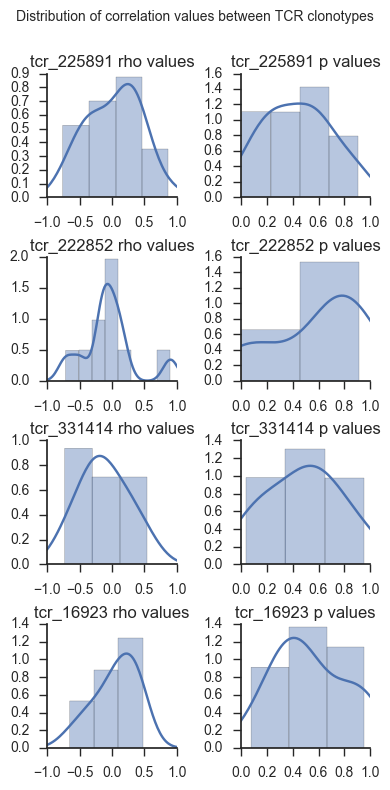

In [88]:
#plot correlation coefficients and pvalues for each TCR epitope
fig = plt.figure(figsize=(4, 8))
plt.suptitle('Distribution of correlation values between TCR clonotypes')

plt_count = 1
for tcre in sprmn_top_tcre:
    ax = fig.add_subplot(4,2,plt_count)
    sns.distplot([x[0] for x in sprmn_top_tcre[tcre].values()]) #coefficients
    plt.title(tcre + " rho values")
    plt.xlim(-1, 1)
    plt_count += 1
    
    ax = fig.add_subplot(4,2,plt_count)
    sns.distplot([x[1] for x in sprmn_top_tcre[tcre].values()]) #pvals
    plt.title(tcre + " p values")
    plt.xlim(0, 1)
    plt_count += 1

sns.despine()
plt.tight_layout()
plt.subplots_adjust(top=0.9)

So our correlations are not really shifted one way or the other, indicating that over all, TCR clonotypes of the same TCR epitopes within the persistent TCR do not greatly covary in time (in Subject01). Individual TCR clonotypes do covary or even have very negative correlations, but there is not signal of a strong enrichment for either of these patterns.

Let's move on to look at TCRs that arise partway through the analysis, BUT before we do that, let's get a better handle on the rules of the game for identifying the persistent TCR.

## Identifying the persistent TCR repertoire
So if we define the persistent TCR as those epitopes that are found across all time points, what are other ways to identify them?

1. Does the overlap over 1 year capture this population? 6 months? 2 months?
2. Does the overlap in N consecutive samples capture this population?
3. Does being public or abundance help determine or predict persistant TCRs?

In [6]:
#let's get TCR repertoire for sets of interests (still only looking at Subject01)
tcre_sets = sub1_pbmc_timecourse.groupby('sample')['tcr_epitope'].unique()

In [12]:
#get set intersections of interest
pers_tcr = set(sub1_pers_timecourse['tcr_epitope'])
one_yr = set(tcre_sets['s1_110316_PBMC']).intersection(tcre_sets['s1_120320_PBMC'])
six_mon_1 = set(tcre_sets['s1_110316_PBMC']).intersection(tcre_sets['s1_110915_PBMC'])
six_mon_2 = set(tcre_sets['s1_110915_PBMC']).intersection(tcre_sets['s1_120320_PBMC'])
first_3 = set(tcre_sets['s1_110316_PBMC']).intersection(tcre_sets['s1_110415_PBMC'], 
                                                         tcre_sets['s1_110512_PBMC'])
first_4 = set(tcre_sets['s1_110316_PBMC']).intersection(tcre_sets['s1_110415_PBMC'], 
                                                         tcre_sets['s1_110512_PBMC'],
                                                         tcre_sets['s1_110609_PBMC'])

So the overlap in 1 year may have fewer TCRs than 2 consective months (35 versus 25 K TCRs), but the difference is still very great between that and the persistent TCR of 7K TCRs.

In [ ]:
#look at how many TCRs are in the shared TCR in at least N consecutive samples
intersection_vals = []
for i in range(1,9):
    tcrs = set.intersection(*[set(tcre_sets[x]) for x in sample_list[:i]])
    intersection_vals.append(len(tcrs))

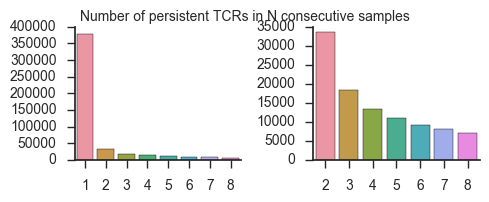

In [46]:
#plot the number of common TCR epitopes in the first N samples
fig = plt.figure(figsize=(5, 2))
plt.suptitle('Number of persistent TCRs in N consecutive samples')

ax1 = fig.add_subplot(1,2,1)
sns.barplot(x=np.arange(1, 9), y=intersection_vals)

ax2 = fig.add_subplot(1,2,2)
sns.barplot(x=np.arange(2, 9), y=intersection_vals[1:])

sns.despine()
plt.tight_layout()

So with these cumulative plots with 3 months of consectutive sampling we get down below 20K TCRs and 4 months gets below 15K, but this is still not all that discerning. Does using an abundance cut off make sense?

Look for TCRs that exhibit the mirror behavior, i.e., they last in the later samples and arise midway through the collections.

In [47]:
#look at how many TCRs are in the shared TCR in N consecutive samples, starting from the end
intersection_vals_rev = []
for i in range(1,9):
    tcrs = set.intersection(*[set(tcre_sets[x]) for x in sample_list[-i:]])
    intersection_vals_rev.append(len(tcrs))

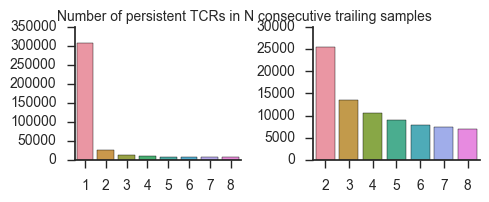

In [51]:
#plot the number of common TCR epitopes in the last N samples
fig = plt.figure(figsize=(5, 2))
plt.suptitle('Number of persistent TCRs in N consecutive trailing samples')

ax1 = fig.add_subplot(1,2,1)
sns.barplot(x=np.arange(1, 9), y=intersection_vals_rev)

ax2 = fig.add_subplot(1,2,2)
sns.barplot(x=np.arange(2, 9), y=intersection_vals_rev[1:])

sns.despine()
plt.tight_layout()

In [52]:
print(intersection_vals)
print(intersection_vals_rev)

[378865, 33601, 18368, 13514, 10997, 9141, 8218, 7012]
[307479, 25417, 13604, 10561, 8889, 7956, 7415, 7012]


These numbers do not indicate whether or not a given TCR is present in only the early samples (which would indicate extinction) or in only the later samples (which would relect new generation of TCRs). They do not exclude TCRs that are found earlier or later.

### Look for TCRs that arise or go extinct permanently during the time course
To find these TCRs, we need to identify TCRs that are shared in the beginning, end, or middle and establish whether they appear anywhere else. We can do this by comparing the set of TCRs that occur in n samples with the set of TCRs that occur in n consecutive samples. The intersection of these sets ought to be the desired TCRs.

In [10]:
#find TCRs that disappear
disappear_sets = {}
for i in range(1,9):
    #get TCRs in i consecutive samples
    consecutive_tcrs = set.intersection(*[set(tcre_sets[x]) for x in sample_list[:i]])
    #get TCRs found in only i samples
    i_tcrs = sub1_epi_occurence.loc[sub1_epi_occurence['num_occ_in_sub1_pbmc'] == i]['tcr_epitope'].unique()
    #get intersection
    disappear_sets[i] = set(i_tcrs).intersection(consecutive_tcrs)

In [13]:
#find TCRs that appear
appear_sets = {}
for i in range(1,9):
    #get TCRs in i consecutive samples
    consecutive_tcrs = set.intersection(*[set(tcre_sets[x]) for x in sample_list[-i:]])
    #get TCRs found in only i samples
    i_tcrs = sub1_epi_occurence.loc[sub1_epi_occurence['num_occ_in_sub1_pbmc'] == i]['tcr_epitope'].unique()
    #get intersection
    appear_sets[i] = set(i_tcrs).intersection(consecutive_tcrs)

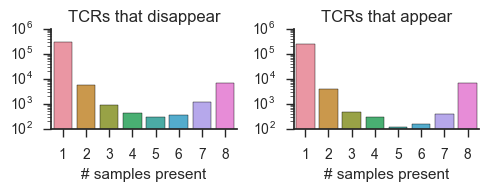

In [18]:
#plot TCRs that disappear and appear
fig = plt.figure(figsize=(5, 2))

ax1 = fig.add_subplot(1,2,1)
tmp = disappear_sets.items()
sns.barplot(x=[x[0] for x in tmp], y=[len(y[1]) for y in tmp])
plt.title('TCRs that disappear')
plt.xlabel('# samples present')
plt.yscale('log')

ax1 = fig.add_subplot(1,2,2)
tmp = appear_sets.items()
sns.barplot(x=[x[0] for x in tmp], y=[len(y[1]) for y in tmp])
plt.title('TCRs that appear')
plt.xlabel('# samples present')
plt.yscale('log')

sns.despine()
plt.tight_layout()

So interestingly, there is an odd uptick in TCRs that appear in the first or last 6-7 samples only, perhaps because these TCRs are part of the persistent TCR repertoire, but only happened to be missed in the last sampling. There do seem to be a bit more TCRs that disappear than reappear, but this difference is marginal. The lowest frequency seems to be lowest at 5 samples (TCRs that were around for 5 samples and then disappeared, or appeared after 3 samples). This creates another bimodal curve suggesting a distinct difference in those TCRs that are reliably present, and those that are rare enough or get cut out of the repertoire.

This might suggest that samples from the 6, 7, and 8 categories are the true persistent TCR, and the others are the rare TCR.